<a href="https://www.kaggle.com/iprogrammer/wids-2022-datathon-maastricht-2nd-day?scriptVersionId=86987269" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# WiDS Maastricht Datathon 2022 Pre-training Day-2 Notebook #


Climate change is one of the most urgent threats humanity is facing. WiDS datathon brings a prediction challenge this year with a focus on mitigating the effects of climate change by means of energy efficiency. This notebook is created to provide the second day training for the datathon organized by Maastricht University in the framework of WIDS Datathon 2022. The aim is to present and explain the different steps in the machine learning pipeline so others can implement them based on their preferences.
The data consists of roughly 100k observations of building energy usage records collected over 7 years and a number of states within the United States. 
Features include building characteristics and weather data for the location of the building, and as target variable the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). The task is to predict the Site EUI for each row in the dataset.

The notebook is brought to you by [Yenisel Plasencia Calaña](https://www.linkedin.com/in/yenisel-plasencia-cala%C3%B1a-phd-10144190/), [Chang Sun](https://www.linkedin.com/in/chang-sun-maastricht/), [Carlos Utrilla Guerrero](https://nl.linkedin.com/in/carlos-utrilla-guerrero-97ba7b31), [Parveen Kumar](https://nl.linkedin.com/in/parveensenza).

**Main steps presented**

- Loading the data
- Exploring missing values
- Handling missing values
- Different types of data exploration
- More data cleaning, removing correlated features 
- Feature encoding and scaling
- Feature engineering
- Outlier detection
- Feature selection
- Splitting the data into training and validation
- Training individual regression models
- Training a combined model
- Creating submission
- Model explainability



### Let's first import all the libraries we will use and load the train and test sets from Kaggle. After loading the data, we show the number of samples for each set and the first ten rows of our training data.

In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import xgboost
import catboost
import lightgbm as lightgbm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
## Load the data 
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
train = pd.read_csv("../input/widsdatathon2022/train.csv")
test = pd.read_csv("../input/widsdatathon2022/test.csv")

print("Number of train samples are",train.shape)
print("Number of test samples are",test.shape)
categorical_features = ['State_Factor', 'building_class', 'facility_type']

numerical_features=train.select_dtypes('number').columns
train.info()


../input/widsdatathon2022/train.csv
../input/widsdatathon2022/test.csv
../input/widsdatathon2022/sample_solution.csv
Number of train samples are (75757, 64)
Number of test samples are (9705, 63)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp   

In [2]:
train.head(10)
        


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,6
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,7
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,8
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,29.515952,9


### We explore the missing values with heatmaps

Text(0.5, 1.0, 'Missing values in training Data')

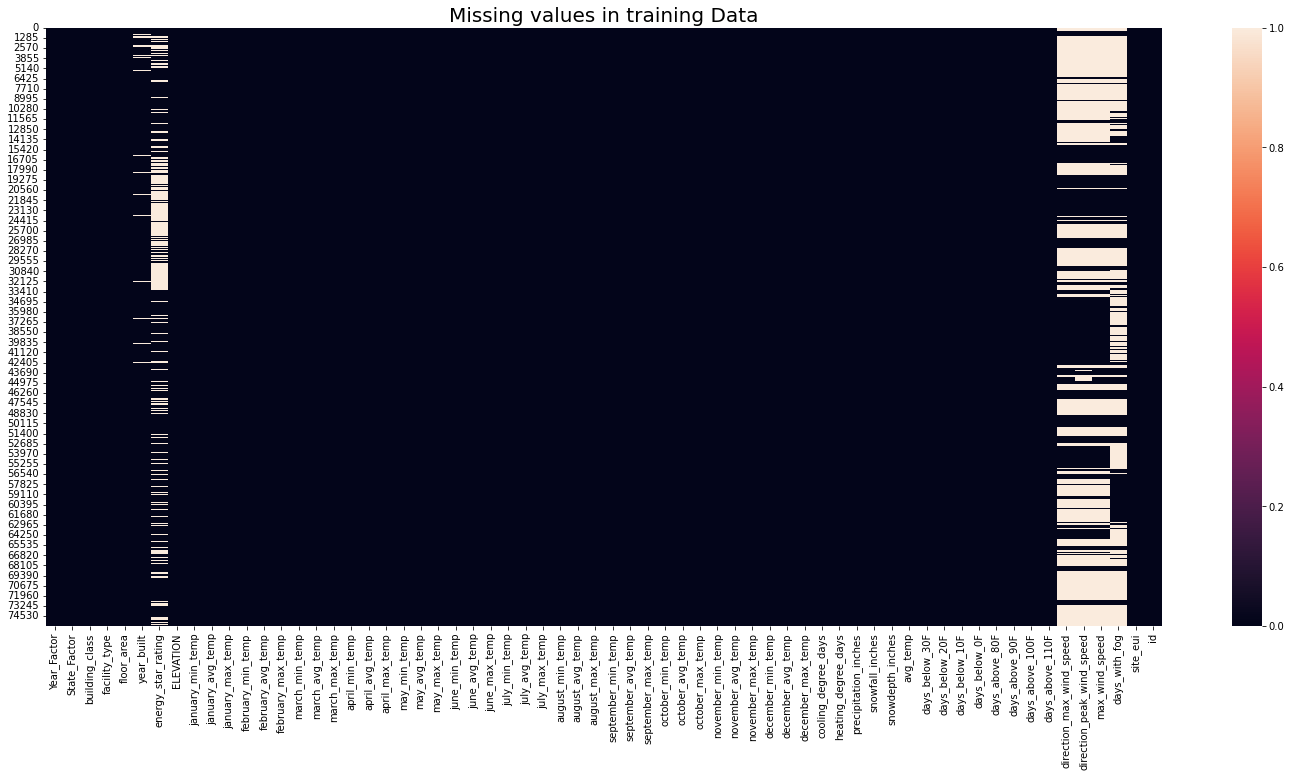

In [3]:
#code copied from https://www.kaggle.com/usharengaraju/wids2022-lgbm-starter-w-b
names = train.columns
plt.figure(figsize = (25,11))
sns.heatmap(train.isna().values, xticklabels=train.columns)
plt.title("Missing values in training Data", size=20)

### Dropping columns that have more than 60% of missing values 

In [4]:

# drop columns with > 60% missing values
lst = train.isna().sum() / len(train)
p = pd.DataFrame(lst)
p.reset_index(inplace=True)
p.columns = ['a', 'b']
low_count = p[p['b'] > 0.6]
todelete = low_count['a'].values
print(todelete)
train.drop(todelete, axis=1, inplace=True)
test.drop(todelete, axis=1, inplace=True)
print("Number of train samples are",train.shape)
print("Number of test samples are",test.shape)




['days_with_fog']
Number of train samples are (75757, 63)
Number of test samples are (9705, 62)


### Next step is missing value imputation, we use a simple imputer that uses the median to avoid the infuence of outliers

In [5]:
missing_columns = [col for col in train.columns if train[col].isnull().any()]
missingvalues_count =train.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]

 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.impute import KNNImputer


# if you want to use an imputer with more options: SimpleImputer   

#strategystring, default=’mean’
#The imputation strategy.

#If “mean”, then replace missing values using the mean along each column. Can only be used with
#numeric data.

#If “median”, then replace missing values using the median along each column. Can only be used
#with numeric data.

#If “most_frequent”, then replace missing using the most frequent value along each column.
#Can be used with strings or numeric data. If there is more than one such value, only the 
#smallest is returned.

#If “constant”, then replace missing values with fill_value. Can be used with strings or numeric data.

#cat_imputer = SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = "missing")
#train_test[categorical_cols] = cat_imputer.fit_transform(train_test[categorical_cols])

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

cat_miss = intersection(missing_columns, categorical_features)
num_miss = intersection(missing_columns, numerical_features)


if len(cat_miss)>0:
    cat_imputer = SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = "most_frequent")
    train[cat_miss] = cat_imputer.fit_transform(train[cat_miss])
    test[cat_miss] = cat_imputer.fit_transform(test[cat_miss])

num_imputer = SimpleImputer(missing_values = np.nan,  strategy = "median")
train[num_miss] = num_imputer.fit_transform(train[num_miss])
test[num_miss] = num_imputer.fit_transform(test[num_miss])


knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
#train[num_miss] = knn_imputer.fit_transform(train[num_miss])
#test[num_miss] = knn_imputer.fit_transform(test[num_miss])

### Plotting the correlation of features will show us those features that are more correlated between them but we can also see the correlation with the target variable

<AxesSubplot:>

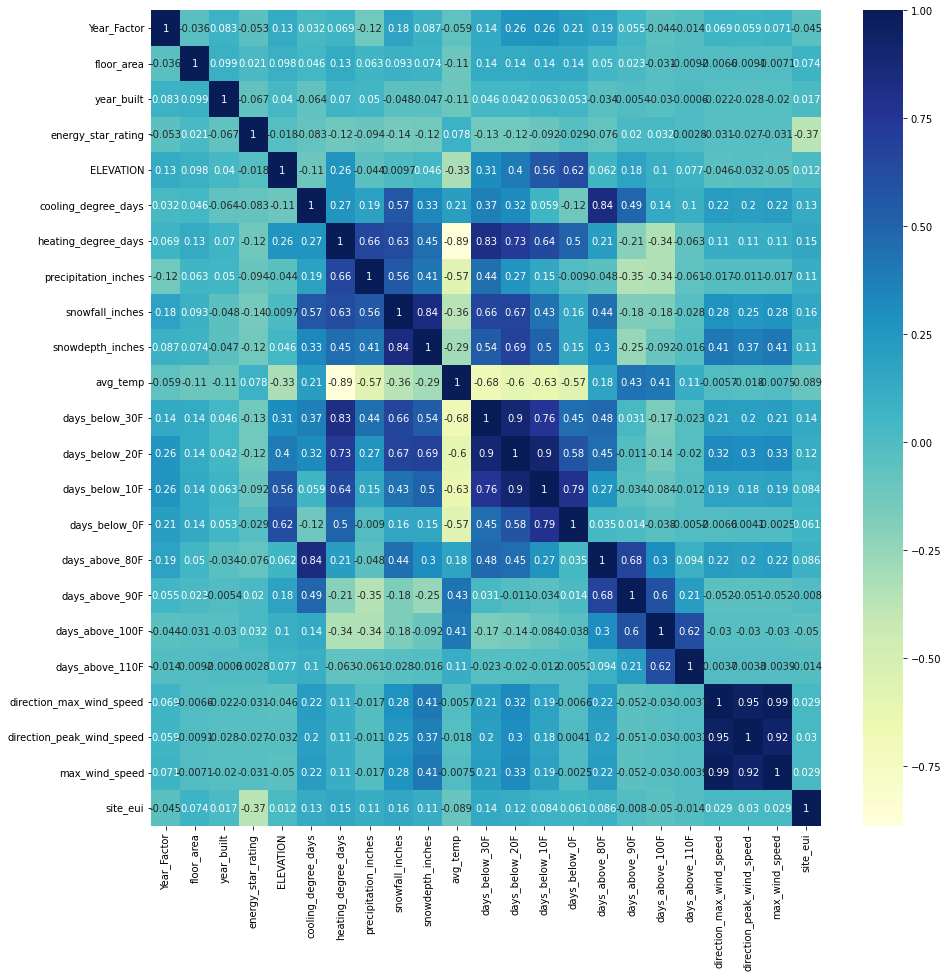

In [6]:
#Correlation map to see how features are correlated with each other and with target
df = train[['Year_Factor', 'State_Factor', 'floor_area', 'year_built', 
                 'energy_star_rating', 'ELEVATION','cooling_degree_days', 
                 'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
                 'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
                 'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
                 'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
                 'direction_peak_wind_speed', 'max_wind_speed',
                 'site_eui']]

plt.figure(figsize = (15,15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

### Plotting the categorical features for the training and test set to find distribution mismatch

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


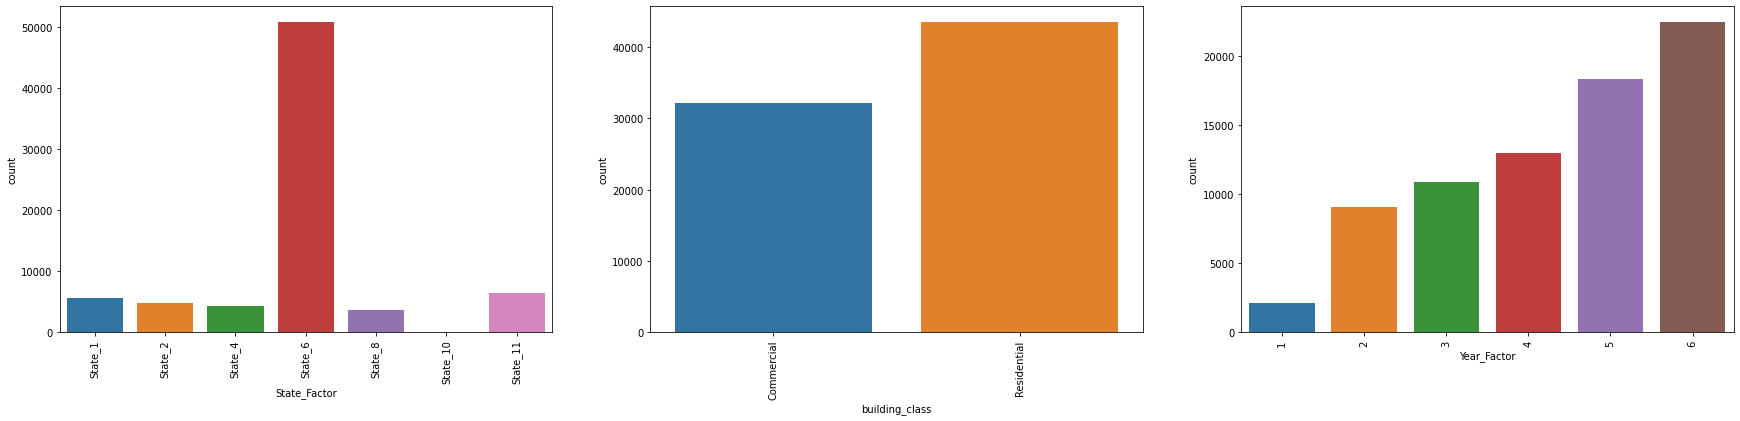

In [7]:
relevant_vis = ['State_Factor', 'building_class', 'Year_Factor'] 
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
for variable, subplot in zip(relevant_vis, ax.flatten()):
    sns.countplot(train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


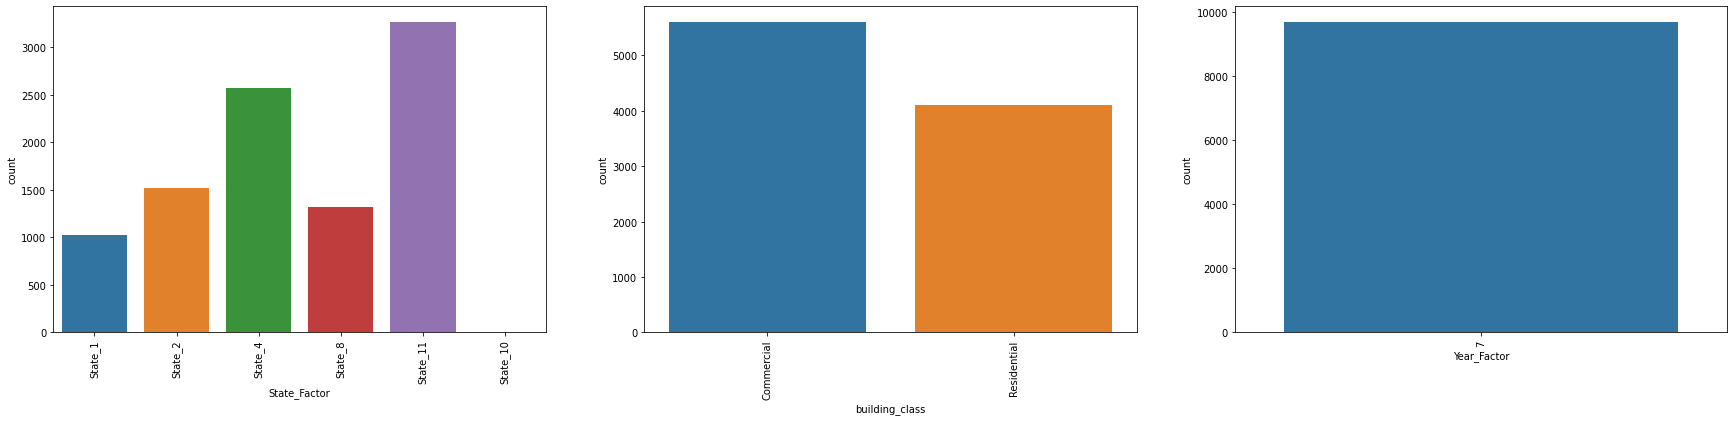

In [8]:
    
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
for variable, subplot in zip(relevant_vis, ax.flatten()):
    sns.countplot(test[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

### Boxplots for some of the numerical features for training and test set can show us outliers and distribution mismatch 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='site_eui'>

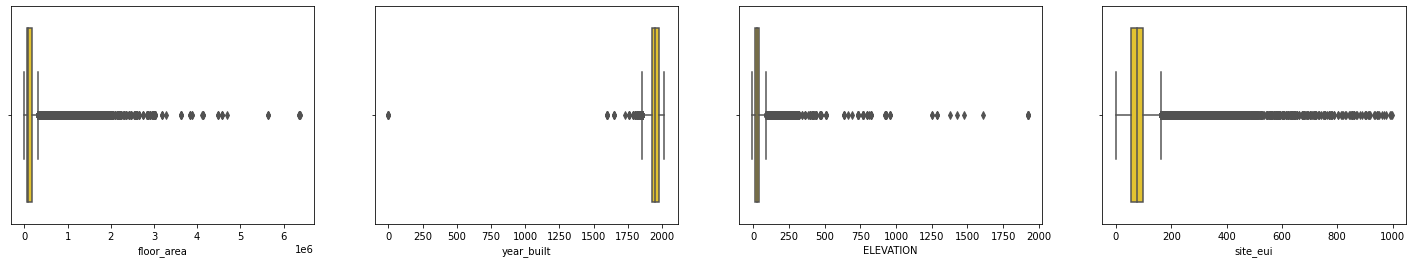

In [9]:
plt.figure(figsize=(25, 4))
plt.subplot(141)
sns.boxplot(train.floor_area , color = "#ffd514")
plt.subplot(142)
sns.boxplot(train.year_built , color = "#ffd514")
plt.subplot(143)
sns.boxplot(train.ELEVATION , color = "#ffd514")
plt.subplot(144)
sns.boxplot(train.site_eui , color = "#ffd514")

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='ELEVATION'>

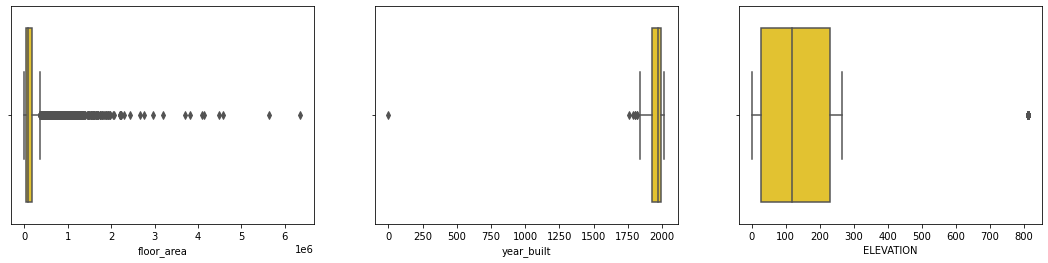

In [10]:
plt.figure(figsize=(25, 4))
plt.subplot(141)
sns.boxplot(test.floor_area , color = "#ffd514")
plt.subplot(142)
sns.boxplot(test.year_built , color = "#ffd514")
plt.subplot(143)
sns.boxplot(test.ELEVATION , color = "#ffd514")


### Showing the histogram distribution for each of the numerical features

In [11]:

#numerical_features = train.select_dtypes('number').columns
#train[numerical_features].hist(bins=15, figsize=(30, 20), layout=(8, 8))

### Energy star rating vs state factor, numerical vs categorical features

<AxesSubplot:xlabel='Year_Factor', ylabel='site_eui'>

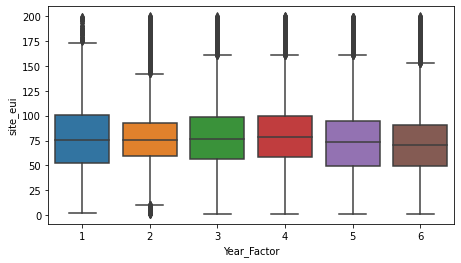

In [12]:
      
vis_df = train[train['site_eui'] <= 200]

plt.figure(figsize=(16, 4))
plt.subplot(121)
sns.boxplot(x=vis_df['Year_Factor'], y=vis_df['site_eui'])
 


<AxesSubplot:xlabel='State_Factor', ylabel='energy_star_rating'>

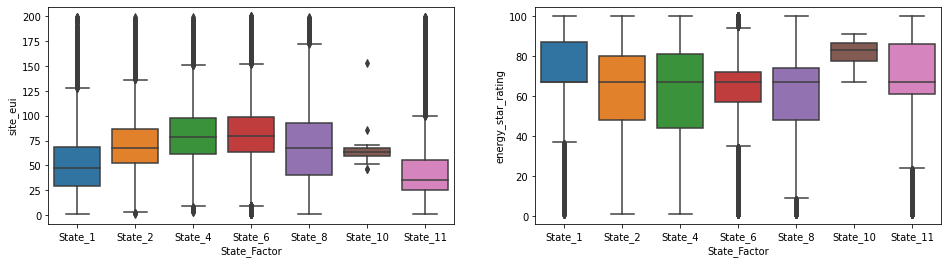

In [13]:

    
plt.figure(figsize=(16, 4))
plt.subplot(121)
sns.boxplot(x=vis_df['State_Factor'], y=vis_df['site_eui'])
plt.subplot(122)
sns.boxplot(x=vis_df['State_Factor'], y=vis_df['energy_star_rating'])

**Considerations** 

- Training data given for year factor 1,2,3,4,5,6 and test data for year 7
- There are outlier values for some of the features, which can be seen from the box plots, year built, ELEVATION
- Distribution of features for the training set is different than distribution of features for the test set e.g. bulding class, facility type
- Most of the samples in the training set have state factor 6, while in the test set this state is missing
- Some of the features are correlated
- Eui target variable seems to slightly decrease per year
- State 6 seems to be the state with highest mean site eui

### Numerical vs numerical features plot with distributions on top of the plots

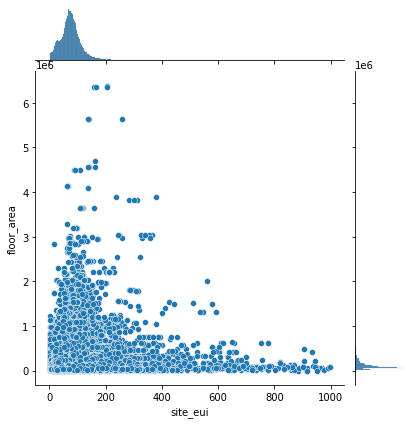

In [14]:

sns.jointplot(x=train['site_eui'], y=train['floor_area']);

#sns.jointplot(x=train['floor_area'], y=train['ELEVATION']);

In [15]:
## visualizations from https://www.kaggle.com/farazrahman/bee-building-energy-efficiency-eda
import plotly.express as px
import plotly.graph_objects as go

temp_year_group = (train.query('year_built >=1900')).groupby("year_built")['site_eui'].agg('median').reset_index()#.sort_values(by ='site_eui', ascending = False)
temp_year_group['year_built'] = temp_year_group['year_built'].astype(str)
fig = px.line(temp_year_group, x="year_built", y="site_eui")
fig.update_layout(title_text='Median site eui of buildings', title_x=0.5, title_y=1, margin=dict(t=30, l=30, r=30, b=30))
fig.show()

In [16]:
temp = train.groupby("energy_star_rating")["site_eui"].agg('median').reset_index()
fig = px.scatter(temp, x="energy_star_rating", y="site_eui")
fig.update_layout(title_text='Median site eui of building when compared with energy star rating', title_x=0.5, title_y=1, margin=dict(t=30, l=30, r=30, b=30))
fig.show()

**Considerations** 

- Buildings with recent year built have a lower site energy usage intensity
- site eui is has an inverse relationship with energy star rating

### Encoding the categorical features so they can be used as input of classifiers, removing correlations, and scaling numerical features

In [17]:


#encoding

label_encoder = LabelEncoder()
for col in categorical_features:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])



#remove columns with low variation

def remove_feature_with_low_var(df, threshold=0.1):
    for col in df.columns:
        if df[col].std() < threshold:
            df = df.drop([col], axis=1)
    return df


#remove correlations

numerical_features=train.select_dtypes('number').columns
num_feature = [col for col in numerical_features]
drop_columns = []
# Create correlation matrix
corr_matrix = train[num_feature].corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
train.drop(to_drop, inplace=True, axis=1)
test.drop(to_drop, inplace=True, axis=1)



# drop uninformative columns

target = train["site_eui"]
train = train.drop(["site_eui","id"],axis =1)
test = test.drop(["id"],axis =1)
temp_test = test
column_names = train.columns
    
#scaling

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



### Feature engineering, creating new features that make sense from the ones given

In [18]:
tr = pd.DataFrame(train, columns = column_names.values)
te = pd.DataFrame(test, columns = column_names.values)
tr["energy_facility"] = tr["floor_area"].div(tr["energy_star_rating"])
te["energy_facility"] = te["floor_area"].div(te["energy_star_rating"])
column_names = tr.columns
train = tr.values
test = te.values

### Outlier detection and deletion, we used an ML method but outliers can also be detected and removed considering any criteria of interests e.g. year built < 200

In [19]:
#outlier detection

#### If you want to inspect outliers or use some type of flag features if the sample is an outlier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
#iso = LocalOutlierFactor(n_neighbors=35, contamination=0.01)
iso = IsolationForest(contamination=0.01)

outliers = iso.fit_predict(train)
# select all rows that are not outliers

train = train[outliers!=-1]
target = target[outliers!=-1]

### Feature selection

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30736.848247379065, tolerance: 20269.3443288363

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 176477.124286592, tolerance: 20269.3443288363

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 28514.463518470526, tolerance: 21266.298745719367

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 33288.5007122457, tolerance: 21266.298745

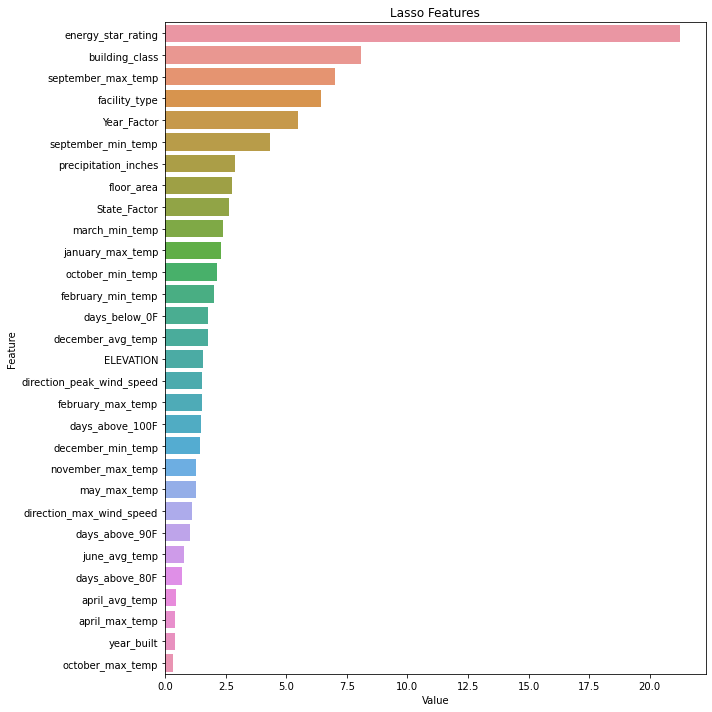

In [20]:

from sklearn.linear_model import LassoCV
lasso = LassoCV().fit(train, target)
importance = np.abs(lasso.coef_)
feature_names = np.array(column_names)

feat_ind = np.argsort(importance)[::-1]
totlasso = 20
feature_imp = pd.DataFrame(columns=['Value','Feature'])
feature_imp.loc[:,'Value'] = importance
feature_imp.loc[:,'Feature'] = column_names

feature_imp = pd.DataFrame(sorted(zip(importance, column_names)), columns=['Value','Feature'])
data=feature_imp.sort_values(by="Value", ascending=False)
data = data.iloc[0:30, :]
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=data)
plt.title('Lasso Features')
plt.tight_layout()
plt.show()

#if we want to use only the selected fetures by LASSO to train the classifiers
#X_train = pd.DataFrame(train,columns = column_names)
#train = X_train.iloc[:, feat_ind]
#X_test = pd.DataFrame(test, columns = column_names)
#test = X_test.iloc[:, feat_ind]
#column_names = train.columns


## a different feature selection method, forward sequential feature selector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=30,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)

#sfs.fit(train, target)
#sfs.k_feature_names_

#if we want to use only the selected fetures by SFS to train the classifiers
#train = pd.DataFrame(train, columns = column_names)
#test = pd.DataFrame(test, columns = column_names)
#train = train[list(sfs.k_feature_names_)]
#test = test[list(sfs.k_feature_names_)]




### Splitting the training set to obtain a validation set that help us to understand the performance of regressors. Note that the prediction is expected for year 7 while training data is for years from 1-6
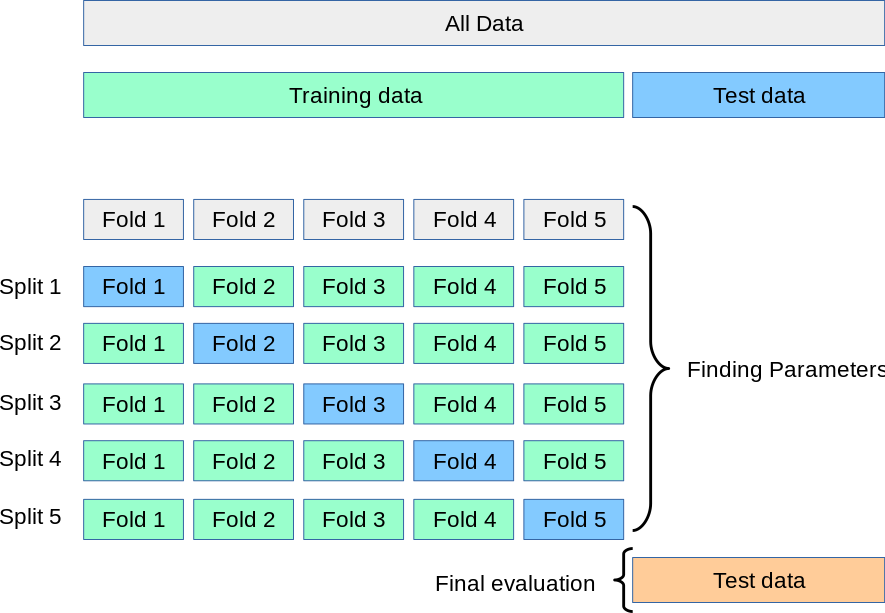


https://scikit-learn.org/stable/modules/cross_validation.html 

In [21]:
#splitting into training and validation sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.2, random_state = 50)



### Training individual models, as this is a problem where the outputs are continuous values it is better framed as a regression problem and not a classification one.

In [22]:
#model training and testing

xgboost_model = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=10) #gamma=0, subsample=0.75, colsample_bytree=0.4,
xgboost_model.fit(X_train,y_train)
y_pred = xgboost_model.predict(X_test)
RMSE1 = math.sqrt(np.square(np.subtract(y_pred,y_test)).mean())
print(RMSE1)

#xgboost_model.fit(train, target)
#res = pd.DataFrame(xgboost_model.predict(test))
#res.to_csv("cl1.csv", index = False)


#lgbm_model = lightgbm.LGBMRegressor(n_estimators=1000,learning_rate=0.05, max_depth=10)
#lgbm_model.fit(X_train,y_train)
#y_pred = lgbm_model.predict(X_test)
#RMSE2 = math.sqrt(np.square(np.subtract(y_pred,y_test)).mean())
#print(RMSE2)

#lgbm_model.fit(train, target)
#res = pd.DataFrame(lgbm_model.predict(test))
#res.to_csv("cl2.csv", index = False)


#Catboost classifier
#cboost_model = catboost.CatBoostRegressor(learning_rate=0.05, depth=10, loss_function = 'RMSE', eval_metric = 'RMSE', iterations = 5000, verbose=False)
#cboost_model.fit(X_train, y_train)
#y_pred = cboost_model.predict(X_test)
#RMSE3 = math.sqrt(np.square(np.subtract(y_pred,y_test)).mean())
#print(RMSE3)

#cboost_model.fit(train, target)
#res = pd.DataFrame(cboost_model.predict(test))
#res.to_csv("cl3.csv", index = False)

#xgboost_ = pd.read_csv('cl1.csv')
#lgbm_ = pd.read_csv('cl2.csv')
#cboost = pd.read_csv('cl3.csv')

#res = 0.5*xgboost_.values + 0.4*lgbm_.values + 0.3*cboost.values
#sub = pd.read_csv("/kaggle/input/widsdatathon2022/sample_solution.csv")
#sub["site_eui"] = res
#sub.to_csv("submission_voting_simple.csv", index = False)



36.58511485631571


In [23]:
# Grid search of the best parameters
from sklearn.model_selection import GridSearchCV


#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#xgboost_model = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=10) #gamma=0, subsample=0.75, colsample_bytree=0.4,
#clf = GridSearchCV(xgboost_model, parameters)
#clf.fit(train, target)

### Training and testing a voting regressor model

In [24]:

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
#from functools import partial
#from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif


models = list()
# create the pipeline
#pipe = Pipeline([('ContinuousFeturesSelector',ce), ('m', clf3)])
# add as a tuple to the list of models for voting
models.append(('xgboost', xgboost_model))
#models.append(('lgbm', lgbm_model))
#models.append(('cgboost', cboost_model))
#models.append(('pipe_NN', clf3))

# define the voting ensemble

#model = VotingRegressor(estimators=models,weights=[6,4,3]) 
#model.fit(X_train,y_train)
#y_pred = model.predict(X_test)
#RMSE_V = math.sqrt(np.square(np.subtract(y_pred,y_test)).mean())
#print("combined voting RMSE is: ",RMSE_V)


### Training using the whole training set for higher accuracy and creating the submision file with the results for the test set

In [25]:


#model.fit(train, target)

#res = model.predict(test)
#sub = pd.read_csv("/kaggle/input/widsdatathon2022/sample_solution.csv")
#sub["site_eui"] = res
#sub.to_csv("submission.csv", index = False)


### Feature importances and influences on the outcomes using SHAP values

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:108: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



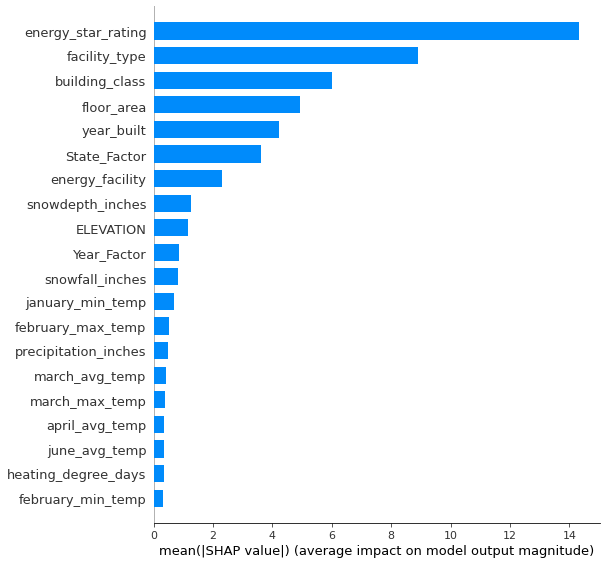

In [26]:
#explanations code from https://www.kaggle.com/shreyasajal/wids-datathon-2022-explainable-ai-walkthrough

X_test_ft=pd.DataFrame(X_test, columns=column_names)

explainer = shap.Explainer(xgboost_model)
shap_values = explainer(X_test_ft)

shap.summary_plot(shap_values, X_test_ft,plot_type="bar")



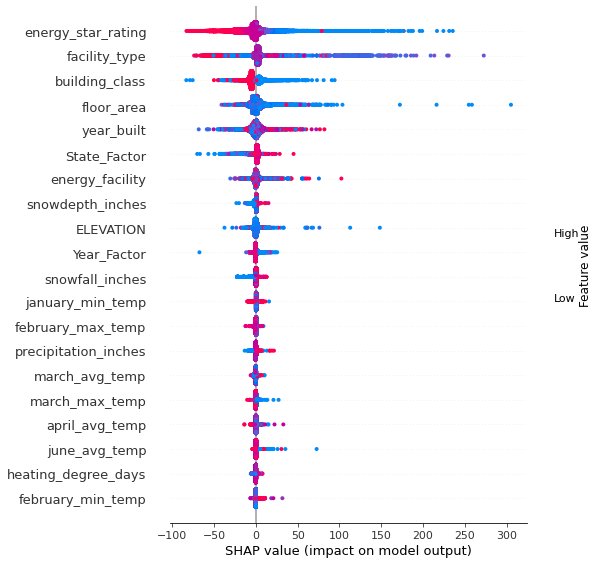

In [27]:

shap.summary_plot(shap_values, X_test_ft)

